In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ML_utils import load_data,load_data_test_set, total_day_eve_night_grouping
df =pd.read_csv('train.csv')

### UNCOMMENT THIS PART TO GROUP FEATURES
feature_engineering = True
df=total_day_eve_night_grouping(df,grouping=feature_engineering)
exclude_list=['state']
# exclude_list = [feature_name for feature_name in df.columns if feature_name not in['number_vmail_messages','number_customer_service_calls','total_charges','churn']]
one_hot_on = True
normalize_on = True
oversample_on= False


###################
#### LOAD DATA ####

X_train,y_train,X_val,y_val,X_test,y_test,columns = load_data(df,exclude=exclude_list,one_hot=one_hot_on,normalize_=normalize_on,oversample=oversample_on)


X_train.shape

y_train=y_train.ravel()
y_val=y_val.ravel()


In [40]:
X_train.shape

(2975, 14)

In [41]:
from sklearn.neural_network import MLPClassifier

In [42]:
import optuna
from sklearn.metrics import mean_squared_error
def objective_nn(trial):
    hidden_layers= trial.suggest_categorical('hidden_layer_sizes', [(64,128,100), (64,128), (100,100,100,100)])
    alpha = trial.suggest_float('alpha', 0.05, 1)
    # solver = trial.suggest_categorical('solver', ['adam', 'lbfgs', 'sgd'])
    clf = MLPClassifier(hidden_layer_sizes=hidden_layers, solver='adam', alpha=alpha, max_iter=5000, random_state=69)
    clf.fit(X_train, y_train)
    
    accuracy = clf.score(X_val, y_val)
    
    return accuracy


In [43]:
from sklearn.ensemble import RandomForestClassifier
def objective_rf(trial):
    n_estimators = trial.suggest_int('n_estimators', 2, 200)
    max_depth = trial.suggest_int('max_depth', 1, 32)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    # solver = trial.suggest_categorical('solver', ['adam', 'lbfgs', 'sgd'])
    clf=RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, random_state=69)
    clf.fit(X_train, y_train)
    
    accuracy = clf.score(X_val, y_val)
    
    return accuracy


In [44]:
study = optuna.create_study(direction='maximize')
study.optimize(objective_rf, n_trials=10)

[I 2024-05-19 20:51:09,200] A new study created in memory with name: no-name-7d84a59e-5c42-40de-9d4b-b1f601f68372


[I 2024-05-19 20:51:09,680] Trial 0 finished with value: 0.9701726844583988 and parameters: {'n_estimators': 189, 'max_depth': 28, 'min_samples_split': 9}. Best is trial 0 with value: 0.9701726844583988.
[I 2024-05-19 20:51:10,033] Trial 1 finished with value: 0.9701726844583988 and parameters: {'n_estimators': 142, 'max_depth': 21, 'min_samples_split': 9}. Best is trial 0 with value: 0.9701726844583988.
[I 2024-05-19 20:51:10,090] Trial 2 finished with value: 0.9607535321821036 and parameters: {'n_estimators': 33, 'max_depth': 6, 'min_samples_split': 8}. Best is trial 0 with value: 0.9701726844583988.
[I 2024-05-19 20:51:10,324] Trial 3 finished with value: 0.9748822605965463 and parameters: {'n_estimators': 94, 'max_depth': 18, 'min_samples_split': 5}. Best is trial 3 with value: 0.9748822605965463.
[I 2024-05-19 20:51:10,455] Trial 4 finished with value: 0.9434850863422292 and parameters: {'n_estimators': 85, 'max_depth': 5, 'min_samples_split': 2}. Best is trial 3 with value: 0.974

In [45]:
study.best_params


{'n_estimators': 94, 'max_depth': 18, 'min_samples_split': 5}

In [46]:
clf=RandomForestClassifier(n_estimators=study.best_params['n_estimators'], max_depth=study.best_params['max_depth'], min_samples_split=study.best_params['min_samples_split'], random_state=69)

In [47]:
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=18, min_samples_split=5, n_estimators=94,
                       random_state=69)

In [ ]:
from sklearn.model_selection import TunedThresholdRandomForestClassifier

clf = TunedThresholdRandomForestClassifier(n_estimators=study.best_params['n_estimators'], max_depth=study.best_params['max_depth'], min_samples_split=study.best_params['min_samples_split'], random_state=69)

In [48]:
clf.score(X_val, y_val)

0.9748822605965463

In [49]:
from sklearn.metrics import confusion_matrix
y_pred=clf.predict(X_val)
confusion_matrix(y_val, y_pred)


array([[538,   1],
       [ 15,  83]])

In [50]:
y_pred=clf.predict_proba(X_val)[:,1]

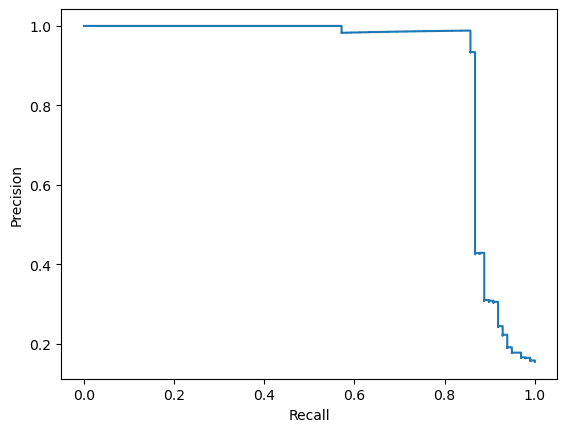

In [52]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

precision, recall, _ = precision_recall_curve(y_val, y_pred)
pr_display = PrecisionRecallDisplay(precision=precision, recall=recall).plot()


In [53]:
from sklearn.ensemble import GradientBoostingClassifier

clf_gb=GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=69)

clf_gb.fit(X_train, y_train)


GradientBoostingClassifier(random_state=69)

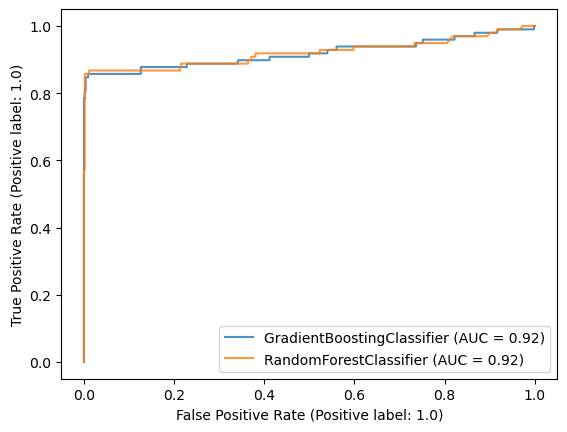

In [54]:
ax = plt.gca()
gb_disp = RocCurveDisplay.from_estimator(clf_gb, X_val, y_val,ax=ax,alpha=0.8)
rf_disp.plot(ax=ax,alpha=0.8)